# Mike Nebesniuk - Capstone Project

# With machine learning, can we determine if a photograph is capable of winning a photography contest.

### mike.nebesniuk@gmail.com

For my CapStone project for BrainStation I have chosen to investigate whether it is posible to use machine learning to determine if a photography is capable of winning a photography contest or not. 

As a part-time professional photographer I have always found it confusing when I saw what people considered to be award winning photographs. I would see blurry photos that people raved about, I would see amazing photos that people ignored. So I decided to take winning photographs from many landscape contests and compare them to the photos from that same contest that did not win. In order to accomplish this I plan to take the top 100-200 from each contest (These contests often have 30,000 images so the top 100-200 are the top of the top images. I will then get the lowest rated photos I can to compare these images too.

In order to compare the images I get, I plan to get between 3000-5000 of each type of photo. I will then use Convoluted Neural Networks (CNN's) to compare the images I find. Once I have made the model I will Introduce new photos that are clearly good or bad photos to see how they fit into the model.

## In this notebook

In this notebook you will find CNN modeling and conclusions

## Import Functions

In [1]:
# Imports
# The usual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Importing tf tools
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
import matplotlib.image as mpimg
import cv2

# Premise

In this notebook we will work on modelling the data with a CNN Neural Network. This data will be worked on with other processes in other notebooks, but because the Neural Network is so resource centric, it gets its own notebook. We will be working with all the photos found in the previous notebook. For the Neural network the photos have been seperated into good photos, or photos that have been deemed to be potentially contest winning photos, and bad photos, or photos that have not won a contest. In the end we will run new photos through the system to see if they can be determined to be award winning or not.

# Open up the images

Here we are going to setup a path to the photos stored locally so that we do not have to link to them every time we need them. This link will work as long as the files are stored in the directory that the notebook is stored in, no matter what computer it is run from.

In [2]:
Landscape = 'Photos/'

## Variables

In the section below we will establish some variables that will be used throughout the rest of the notebook. 
   * Classes - This dataset will have 2 classes, Award winning photos (good), and not award winning photos (bad). These images were obtained through the website viewbug. They host photos for photographers and have monthly contests. Tbe good photos come from the high end of the landscape photography contests, while the bad photos come from the lower end of the landscape photo section.
   * Pixels - This represents the size of a photo, the original photo sizes were about 400x170 pixels. The new photo size will be 256x256 pixels. That means that each photo 256 pixels long and 256 pixels tall.
   * Channels - This data set will be looked at as colour photoghraphy. Colour is listed as RGB colours, which is represented by 3 colours. Mono colour would be black and white, or 1 colour.
   * Batch Size - The average batch size is 32, originally we had an arbitrary number of 50, but we will change that to 35, to more match the average batch size.

In [3]:
# Saving variables that we will be calling on 

# As stated above, we have 2 classes, good (award winning), and bad (not award winning)
classes = 2

# In an attempt to help lower the cpu power used by this, we will turn the images to 256x256 pixel images. This will also
# take care of the landscape vs portrait issue as it will stretch and fit into a square.
pixels = 256

# They are colour images so they have 3 channels 
channels = 3

# The average batch size is 32, we will use 35.
batch_size = 35



# Setting up the Module

To begin setting up the module, we will first instantiate the 'ImageDataGenerator()' s and set the parameters according to the preprocessing and augmentation that we want done to each image. The Image data generator allows us to augment the image to fit the images around it. It allows us to change the length and width of the photo (in pixel length), rotate the image, flip it, change the brightness and much more.

Here we will also setup and set the size of the validation set. This set will be used to evaluate each epoch.

## Instantiate the Image Data Generator

In [4]:
# Instantiating ImageDataGenerator(), seperate the validation set
Landscape_train = ImageDataGenerator(rescale=1./255,       #This changes the colour designation from 0-255, to less than 1
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                   fill_mode='reflect',
                                   validation_split=0.25)

Some of the variables are:
   * rescale - This scales down the colour designation number from 0-255 to make it -255 to 0. Making the number less than 0 makes for smaller data, and thus calculations are quicker.<br/>
   * horizontal flip - This allows the image to be flipped about the horizontal axis to try to make it resemble images near it.<br/>
   * Vertical flip - This allows the image to be flipped about the vertical axis to try to make it resemble the images near it. <br/>
   * Zoom Range - This dictates how much the image data generator is allowed to zoon into the images to make them look more like the rest of the images.<br/>
   * Shear Range - This allows for adjustment should the image need to be rotated about the axis to solve perception angles. This adjustment will allow the photo to be viewed my the image data generator.
   * Fill Mode - This allows for the areas outside the boundary of the image to filled to make a complete image, the fill method is reflection, so it will reflect the existing image onto the missing area.
   * Validation Split - This is the percentage of the whole data sat that will be put aside for the validation set. Often it is 10%, but since this set was a bit smaller, we went with 20%.



In [5]:
# Here we will generate the training set, note the shuffle is set to true.
Photos_train = Landscape_train.flow_from_directory(Landscape+'Classes/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True, subset='training')

Found 7338 images belonging to 2 classes.


Variable definitions from above:<br/>
   * Landscape + CLasses - Landscape is the variable to the path where the photos are located listed above. Classes is the directory below the 'photos' directory, it contains the 2 class directories for the photographs.<br/>
   * target size - This dictates the size of the image the module will work with. Earlier we established the variable pixels, now those pixels are being used for the target size.
   * Color Mode - Earlier we stated that the photos would be analyzed in colour, and we set channels to 3. This variable also set the colour mode of the images, and here we will use RGB (Red Green Blue) the standard for defining colour as each colour is made up of the colours of Red Green and Blue.
   * Batch Size = This dictates the number of photos in each batch. Originally we had chosen a random number of 50 for our batch size, seeing that the average is 32, let us change to a more reasonable number of 35. This more closely resembles the average of 32.
   * Class Mode - We have chosen categorical originally, it allows a 2D numpy array of one-hot encoded labels and supports multi-lable output as well. we might also conside 'input' as it accepts images identical to the source. We cannot use binary which uses a 1D numpy array of binary labels as our photos are not in that format.
   * Shuffle - This determines whether the images are shuffled or not. If the model is shuffled each data point create an independent change on the model, thus the point isn't biased on the by the points before them in the original order, and thus less overfitting of the model.
   * Subset - This determines where the data is stored, this time we stored it as a training set.
    

In [6]:
# We will now generate the validation set, note the shuffle is set to False.
Photos_valid = Landscape_train.flow_from_directory(Landscape+'Classes/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False, subset='validation')

Found 2445 images belonging to 2 classes.


The variables for this section are very similar to the ones above with some changes:<br/>
   * Shuffle - we shuffled for the training set, no need to re-shuffle for the validation set.
   * Subset - This set we are making the validation set.


# Step Size
To complete all the epoch's we will need to know the size of each step we will need to take to process all the data for each epoch. So with batch size of 35 and about 7825 images in 2 classes, we will need about 223 steps to get through all the photos. Those 223 steps will be run through each epoch, and it will help us train our data better.

In [7]:
# Calculating the step size for both the train and validation sets
step_size_train = Photos_train.samples//Photos_train.batch_size 

step_size_valid = Photos_valid.samples//Photos_valid.batch_size 

# Lets print out the values so we know how many steps there will be.
print(f'Training step size = {step_size_train} \nValidation step size = {step_size_valid}')

Training step size = 209 
Validation step size = 69


# Import the Pretrained VGG16 Network

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters. Info and image below taken from <a href="https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c">Link</a>

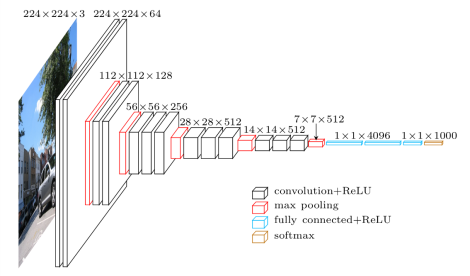

In [8]:
# Import the pretrained VGG16 network, do not include the top layers
pretrained = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(pixels,pixels,channels))

Variable definitions from above:<br/>
   * Weights - Imagenet, imagenet is pretty much the industry standard dataset for large scale visual recognition. Keras has built has several CNN architectures built on the imagenet system
   * Include Top - This variable is used to remove all of the dense layers, otherwise the layers that are fully connected. It also includes the last layer, or the output layer. We are choosing to not include this information, so we will set this variable to false.
   * Pooling - With the removal of the last layer, pooling can be used to down sample the detection of features in feature maps. With the data we have, we have decided to use a global max pooling layer which will flatten the curve.
   *  Input Shape - This describes how the image is shaped before it is passed through. We will use the variables of pixels and channels we defined above to describe the shape here.

In [9]:
# 2.  Set the pretrained layers to non trainable, so that the pretrained layers remain unaltered.
for layer in pretrained.layers:
    layer.trainable=False

**Variable from above**<br/>
   * Pretrained Layers - Trainable - False. The intention of this variable is to determine if we want to change the layers in the  pretrained model or not. Since we are using transfer learning, we do not want the pretrained layers taking on the characteristics of our model, we want it to transfer its information via pretrained weights. Our model will only learn from the weights of the last few layers.

In [10]:
# Display the VGG16 architecture
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

**discuss findings here**<br/>
We can see that trainable params is zero, which we wanted, and the global_max_pooling layer will flatten the data so it will be ready to be inputed to the full-connected (dense) top layers we will add.

# Instantiate the Model

This is where we will start working with the model. Some of the variables used here will include: <br/>
   * model - originally we used a more photo based variable name here but when running the model, but an error kept coming up asking us to use model.fit as the variable, so we changed it back to just model from photo_model.
   * Sequential model - Models in Keras are defined as a sequence of layers. When creating a sequence model, we add layers one at a time until we have formed out network architecture. This is how we are building the model for these photographs, so we will use the seguential model.
   * Dense - This begins the operation using the formula output - activation(dot(input, kernal) + Bias)
   * Relu - The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance. Taken from <a href="https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks//">Link</a><br/>
   * Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

    As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features providing some specialization. Neighboring neurons become to rely on this specialization, which if taken too far can result in a fragile model too specialized to the training data. This reliant on context for a neuron during training is referred to complex co-adaptations.<br/>

    You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.<br/>

    The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data. Taken from <a href="https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/">Link</a><br/>
    
* Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector.<br/>

    The most common use of the softmax function in applied machine learning is in its use as an activation function in a neural network model. Specifically, the network is configured to output N values, one for each class in the classification task, and the softmax function is used to normalize the outputs, converting them from weighted sum values into probabilities that sum to one. Each value in the output of the softmax function is interpreted as the probability of membership for each class. Taken from <a href="https://machinelearningmastery.com/softmax-activation-function-with-python/">Link</a><br/>

In [11]:
# Instantiate the NN model 
model = Sequential()

# Add the pretrained layers 
model.add(pretrained)

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))

# Adding our activation 
model.add(Dense(classes, activation='softmax'))

**Fully-connected dense layer**
Now that the pretrained model is complete, and it has been flattened and pool feature mapped into a sequential column of numbers. We can now add that information into our fully connected dense layer, this will serve to combine our features into more attributes which will predict the classes with greater accuracy.

This means that if we had 2 output classes of photography (award winning and not award winning landscape photography. If we then took those classes and applied them to a neuron that reads '0' as absolutely uncertain that the photo belongs in the award winning class, and a neuron that reads '1' that a photo is absolutely certain that the photo belongs to the award winning photo class. In the final fully connected layer, the neyrons will read values between 0 and 1, this would signify different levels of certainty, like a value of 0.8 would mean that it has a 80% change of being an award winning photo.


**Softmax Activation**
In order to classify the input image based on the training data we to use the softmax function to serve as an activation function that will use the features from the output of these layers.

## Early Stopping

We are going to use an 'early stopping' code to prevent our data from being over trained to our landscape photos. This will stop the epochs should they start over training.

In [12]:
# Initiate early stop based on validation accuracy
EStop = EarlyStopping(monitor='val_acc', patience=5, mode='auto', min_delta=0.0001, verbose=1)

**Variables from above**
   * Monitor - Val Acc - This means we are going to monitor the val accuracy of the data set. This is a variable defined by the early stopping and not one we create.
   * Patience - 5 - This means that after 5 epochs showing no improvement, we will stop training the model.
   * mode - Auto - This basically means that 'val_acc' automatically improves increasing values.
   * min delta - 0.0001 - This is the minimum change in validation accuracy to qualify as an improvement.

## Optimizer

Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.

Adam was presented by Diederik Kingma from OpenAI and Jimmy Ba from the University of Toronto in their 2015 ICLR paper (poster) titled “Adam: A Method for Stochastic Optimization“. I will quote liberally from their paper in this post, unless stated otherwise.

When introducing the algorithm, the authors list the attractive benefits of using Adam on non-convex optimization problems, as follows:

   * Straightforward to implement.
   * Computationally efficient.
   * Little memory requirements.
   * Invariant to diagonal rescale of the gradients.
   * Well suited for problems that are large in terms of data and/or parameters.
   * Appropriate for non-stationary objectives.
   * Appropriate for problems with very noisy/or sparse gradients.
   * Hyper-parameters have intuitive interpretation and typically require little tuning.
   
**In Summary**
   * Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
   * Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
   * Adam is relatively easy to configure where the default configuration parameters do well on most problems.
   Taken From <a href="https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20a%20replacement%20optimization,sparse%20gradients%20on%20noisy%20problems.">Link</a><br/>
   
**Loss**<br/>

   * Categorical Crossentropy - This loss calculator is used when there are two or more label classes, we have 2.

In [13]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 14,978,626
Trainable params: 263,938
Non-trainable params: 14,714,688
_________________________________________________________________


## Results

As you can see, there are a total of almost 15 million parameters (params) from the Vgg16 convoluted network alone.  260 thousand trainable parameters, and about 14.7 million non-trainable parameters.

## Fitting the Model 

In [14]:
# Now let us finally fit the model to the training data.
Photo_History = model.fit_generator(generator=Photos_train,
                                steps_per_epoch=step_size_train,
                                epochs=20,
                                validation_data=Photos_valid,
                                validation_steps=step_size_valid,
                                callbacks=[EStop])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
209/209 [==============================] - 2588s 12s/step - loss: 0.7411 - acc: 0.5431 - val_loss: 0.7141 - val_acc: 0.4787
Epoch 2/20
209/209 [==============================] - 2599s 12s/step - loss: 0.6839 - acc: 0.5702 - val_loss: 0.7121 - val_acc: 0.4932
Epoch 3/20
209/209 [==============================] - 2600s 12s/step - loss: 0.6591 - acc: 0.6016 - val_loss: 0.7053 - val_acc: 0.5275
Epoch 4/20
209/209 [==============================] - 2594s 12s/step - loss: 0.6582 - acc: 0.6053 - val_loss: 0.6973 - val_acc: 0.5487
Epoch 5/20
209/209 [==============================] - 2590s 12s/step - loss: 0.6539 - acc: 0.6044 - val_loss: 0.7144 - val_acc: 0.5180
Epoch 6/20
209/209 [==============================] - 2600s 12s/step - loss: 0.6446 - acc: 0.6258 - val_loss: 0.7061 - val_acc: 0.5304
Epoch 7/20
209/209 [==============================] - 2595s 12s/step - loss: 0.6365 - acc: 0.6266 - val_loss: 0.7092 - val_acc: 0.5350
Epoch 8/20
209/209 [==============================] - 2

## Results

Of the 20 epochs that the model was supposed to, it stoped learning after 18 epochs using the Early Stop function. The Model managed to attain 66.75% accuracy. While this may not seem to be very accurate, the diversity of the photos in this image set is quite large, photos of beaches, sunsets, lighthouses, waterfalls, and more. Landscape photography is traditional a wide and diverse set of photos. 

**Variables from above**
   * Photo_history - This is the variable we are defining here
   * Model Fit Generator - This is what generates the model, it runs in parallel to the model for efficiency. It allows you to do real-time data augumentation on images on the CPU, while training your model on the GPU.
   * Epochs - The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

        One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches. For example, as above, an epoch that has one batch is called the batch gradient descent learning algorithm.

        You can think of a for-loop over the number of epochs where each loop proceeds over the training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified “batch size” number of samples.

        The number of epochs is traditionally large, often hundreds or thousands, allowing the learning algorithm to run until the error from the model has been sufficiently minimized. You may see examples of the number of epochs in the literature and in tutorials set to 10, 100, 500, 1000, and larger.

        It is common to create line plots that show epochs along the x-axis as time and the error or skill of the model on the y-axis. These plots are sometimes called learning curves. These plots can help to diagnose whether the model has over learned, under learned, or is suitably fit to the training dataset. Taken from <a href="https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/">Link</a><br/>
        
   * Steps per epoch - We defined this earlier as Step Size Train, this will define the number of steps per epoch.
   * EStop - We defined this earlier, but this will stop the process if it finds that there is no more change in the training.
   


In [15]:
# check for history object
Photo_History.history

{'loss': [0.713784396648407,
  0.6746689677238464,
  0.6608771681785583,
  0.6559425592422485,
  0.6511260867118835,
  0.6419472098350525,
  0.6342114806175232,
  0.6322055459022522,
  0.6261895298957825,
  0.6221246123313904,
  0.6235182285308838,
  0.6184179782867432,
  0.6170333027839661,
  0.6128749847412109,
  0.6135674118995667,
  0.6068663597106934,
  0.6077620387077332,
  0.6072282195091248],
 'acc': [0.5477201342582703,
  0.5887991189956665,
  0.603313684463501,
  0.6086539626121521,
  0.6157743334770203,
  0.6246747970581055,
  0.6376831531524658,
  0.6367246508598328,
  0.6517869234085083,
  0.6552101969718933,
  0.6580857038497925,
  0.6505545377731323,
  0.6587703824043274,
  0.6586334109306335,
  0.6647952795028687,
  0.6694509387016296,
  0.6654799580574036,
  0.6704094409942627],
 'val_loss': [0.7141397595405579,
  0.7121104598045349,
  0.7052801847457886,
  0.6973108649253845,
  0.7144020795822144,
  0.7061330676078796,
  0.7091702818870544,
  0.7212653756141663,
  0.7

While this is a nice summary of all the accuracy scores, it is a bit difficult to read, we will display it better below in graph form.

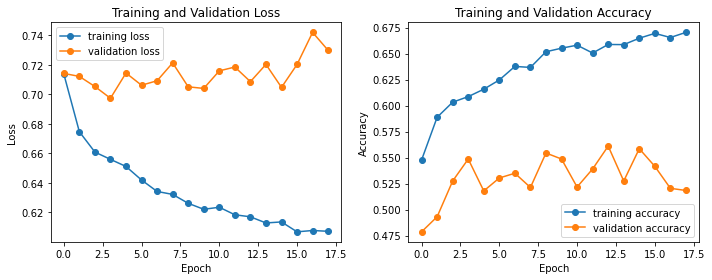

In [16]:
plt.subplots(1,2,figsize =(10,4))

plt.subplot(1,2,1)
plt.plot(Photo_History.history['loss'], marker='o', label='training loss')
plt.plot(Photo_History.history['val_loss'], marker='o', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(Photo_History.history['acc'], marker='o', label='training accuracy')
plt.plot(Photo_History.history['val_acc'], marker='o', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

These graphs ar a lot easier to read. In the loss graphs on the left you can see that the validation set is overfit, the training set los is somewhat over fit, but it isn't too bad. THey meet just under 72%.
The Training and Validation Accuracy graph show the Accuracy of the training set reaches almost 67%, this is the most accuracy we have seen so far. The validation set is quite over fit. Even at a 25% split we think there is just not enough data. The Training set is also a bit over fit now too, maybe too much data was taken from the validation set, or maybe too many epochs were run, either way the model is starting to over fit. We do feel that the trade off of over fit vs accuracy it good at this point. The Photos (data) are very diverse and outliers are expected to make the model over fit quicker.

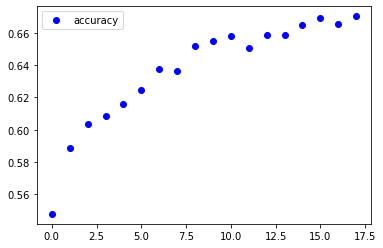

In [17]:
# plotting accuracy and validation accuracy
accuracy = Photo_History.history['acc']
plt.plot(range(len(accuracy)), accuracy, 'bo', label = 'accuracy')
plt.legend()

Similar to the graph above, but its just the accuracy for the training set alone. Its a bit easier to see the points here.

# The Results

With a train/validation split of 25% and running up to 20 epochs (early stop triggered at 18) it appears that the training set only reaches an accuracy of about 67%, while this may seem low the photos were comprised of very differnt images. Narrowing down the constraints suchs as Landscape photos of mountains, or landscape photos of sunsets might make it more accurate, but using the general landscape led to a diverse set of photos, and low accuracy. Changing the aspect ratio of the images made a significate difference. At 64x64 pixels the accuracy was worse than at 256x256 pixels. Changing the training/validation percentage also made significate differences. At 10% the accuracy was worse, the data sets were very over fit, and it would only run through 6 epochs. At 20% the accuracy was lower, the models were less overfit, and it would only run through 9 epochs. At 25% the accuracy was at its best, but the models were more over fit, but it managed to run through 18 epochs before stopping early because it was not learning anything of substance.

## Introduce new photos to the model

In [18]:
# Select your image by providing the relative path:
img = mpimg.imread('Photos\Classes\HDR Barn 4 e.jpg')

Lets resize the image to match the images in the model.

In [19]:
# Resize the image to the required resolution of 256 by 256. 
res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

To see confirm that this works, and just out of curiosity, we can take a peek at the resized image.

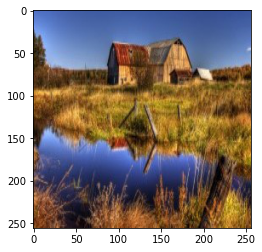

In [20]:
# Let's look at what our resized image looks like!
imgplot = plt.imshow(res)

This is a decent photo that is not included in the original sets, lets see if the model thinks it is potentially award winning or not.

In [21]:
# turn the image into an array form which is what our model needs as an input. 
pred_img = tf.keras.preprocessing.image.img_to_array(
    res, data_format=None, dtype=None
)

Now with the model, we can run a prediction!

In [22]:
# Run the prediction with our food model! 
model.predict(pred_img.reshape(1,256,256,3)) # Reshape for 4D as tensorflow expects.

array([[1., 0.]], dtype=float32)

**From the prediction above, it appears this image is 100% an award winning photo!!**

Now let us try a photo that is less wonderful and see how it does.

In [23]:
# Select your image by providing the relative path:
img2 = mpimg.imread('Photos\Classes\Agawa3.jpg')

In [24]:
# Resize the image to the required resolution of 256 by 256. 
res = cv2.resize(img2, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

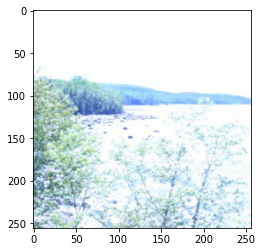

In [25]:
# Let's look at what our resized image looks like!
imgplot = plt.imshow(res)

In [26]:
# turn the image into an array form which is what our model needs as an input. 
pred_img = tf.keras.preprocessing.image.img_to_array(
    res, data_format=None, dtype=None
)

Now with the model, we can run a prediction!

In [27]:
# Run the prediction with our food model! 
model.predict(pred_img.reshape(1,256,256,3)) # Reshape for 4D as tensorflow expects.

array([[1., 0.]], dtype=float32)

**This is also an award winning photo???**

This is very dissappointing, let us try with a photo that was in the 'bad' photo set.

In [28]:
# Select your image by providing the relative path:
img3 = mpimg.imread('Photos\Classes\89499545_widepreview400.jpg')

In [29]:
# Resize the image to the required resolution of 256 by 256. 
res = cv2.resize(img3, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

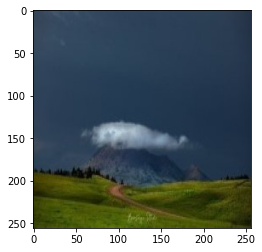

In [30]:
# Let's look at what our resized image looks like!
imgplot = plt.imshow(res)

In [31]:
# turn the image into an array form which is what our model needs as an input. 
pred_img = tf.keras.preprocessing.image.img_to_array(
    res, data_format=None, dtype=None
)

Now with the model, we can run a prediction!

In [32]:
# Run the prediction with our food model! 
model.predict(pred_img.reshape(1,256,256,3)) # Reshape for 4D as tensorflow expects.

array([[1.0000000e+00, 4.0689902e-26]], dtype=float32)

**This is also an award winning photo???**

This is also 100% chance it is a winning photo even though it is in the non award winning data set. This makes us think that the image sets are too similar.

# Conclusion

The images in the two classes are too similar to one another. Since we were only able to able to download the first 3000 images from any one photo contest that is still 3000/30,000 * 100 = 13% or so. Thats still in the top 13% of these contests. Because we were downloading the images manually, we can confirm that even at 4000th place in these contests the photos were generally very good. We don't see a solution to this with the data we have. If we could get to the 30,000 place photos there may be enough of a difference for the model to make the right predictions, but as it stands now we are comparing apples to apples here. The model needs some oranges to make better predictions.